In [ ]:
라이브러리 임포트

In [6]:
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal
from urllib.request import urlretrieve
import matplotlib.pyplot as pylab

In [ ]:
MNIST(필기 숫자) 데이터셋 다운로드

In [8]:
# MNIST data file 다운로드 함수 - Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename): download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename): download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')
## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

print(train_data.shape) # (60000, 784) ## 60k 28 × 28 필기체 숫자
print(test_data.shape) # (10000, 784) ## 10k 28 × 28 필기체 숫자


(60000, 784)
(10000, 784)


In [ ]:
데이터셋 시각화

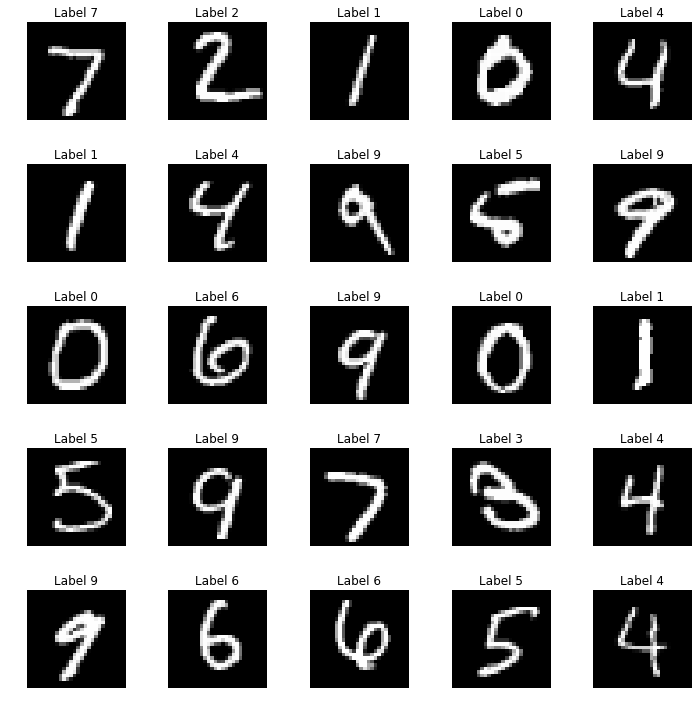

In [10]:
## 벡터로 주어진 숫자를 영상으로 표시하는 함수
def show_digit(x, label):
    pylab.axis('off')
    pylab.imshow(x.reshape((28,28)), cmap=pylab.cm.gray)
    pylab.title('Label ' + str(label))
    
pylab.figure(figsize=(10,10))
for i in range(25):
    pylab.subplot(5, 5, i+1)
    show_digit(test_data[i,], test_labels[i])
    
pylab.tight_layout()
pylab.show()

In [ ]:
최근접 이웃 계산

In [11]:
import time
from sklearn.neighbors import BallTree # 볼 트리 모듈 임포트

## 학습 데이터에서 최근접 이웃 구조 생성
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## 수행시간 계산
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## 테스트 데이터에서 최근접 이웃 예측
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1,\
                                            return_distance=False))
test_predictions = train_labels[test_neighbors]
t_after = time.time()

## 수행시간 계산
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)
# Time to build data structure (seconds): 0.3269999027252197
# Time to classify test set (seconds): 6.457000017166138

Time to build data structure (seconds):  21.50100350379944
Time to classify test set (seconds):  448.0031659603119


In [ ]:
분류기 성능 평가 - 혼동 행렬

In [ ]:
# 분류기 평가
t_accuracy = sum(test_predictions == test_labels) / len(test_labels)
print("t_accuracy", t_accuracy) # 0.9691

import pandas as pd
import seaborn as sn
from sklearn import metrics

cm = metrics.confusion_matrix(test_labels,test_predictions)
df_cm = pd.DataFrame(cm, range(10), range(10))

# pylab.figure(figsize = (10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="g")
pylab.show()

In [ ]:
def fit_generative_model(x, y):
    k = 10 # 레이블 개수 0,1,..., k-1
    d = (x.shape)[1] # 숫자 데이터의 차원수
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    c = 3500 # 정규화를 위한 매개 변수,
                                # 연습문제: 교차검증을 통해 최상의 c 선택하시오.
        
    for label in range(k):
        indices = (y == label)
        pi[label] = sum(indices) / float(len(y))
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1) + c * np.eye(d) # 정규화
    return mu, sigma, pi # 매개 변수 반환

def displaychar(image):
    pylab.imshow(np.reshape(image, (28,28)), cmap=pylab.cm.gray)
    pylab.axis('off')
    pylab.show()
    
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

In [ ]:
테스트 데이터 및 모델 평가에 대한 예측을 위한 사후 확률 계산

In [ ]:
## 각 [test image, label] 쌍에 대한 log Pr(label|image) 계산
k = 10
score = np.zeros((len(test_labels), k))
for label in range(0, k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
        score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
        
test_predictions = np.argmax(score, axis=1)

# 최종 에러수 및 정확도 집계
errors = np.sum(test_predictions != test_labels)
print("The generative model makes " + str(errors) + " errors out of 10000")
t_accuracy = sum(test_predictions == test_labels) / len(test_labels)
print(t_accuracy) # 0.9562

In [ ]:
SVM 분류기

In [ ]:
from sklearn.svm import SVC

clf = SVC(C=1, kernel='poly', degree=2)
clf.fit(train_data,train_labels)
print(clf.score(test_data,test_labels)) # 0.9806

test_predictions = clf.predict(test_data)
cm = metrics.confusion_matrix(test_labels,test_predictions)
df_cm = pd.DataFrame(cm, range(10), range(10))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")
pylab.show()

In [ ]:
기준 값 레이블과 다르게 잘못 예측한 테스트 영상

In [ ]:
wrong_indices = test_predictions != test_labels
wrong_digits = test_data[wrong_indices]
wrong_preds = test_predictions[wrong_indices]
correct_labs = test_labels[wrong_indices]
print(len(wrong_preds)) # 194

pylab.title('predicted: '+ str(wrong_preds[1]) +', actual:' + str(correct_labs[1]))
displaychar(wrong_digits[1])